### Build a neural network from sractch

Using topologic sort to build a graph

Node:

- forward: Function, how to calculate the inputs
- backwards: Function, how to get the gradients when backpropogation
- gradients: Mapper, the gradient map the this node of its inputs node
- inputs: List, the input nodes of this node
- outputs: List, the output node of this node

想象以下代码是一张多种节点构成的图

#### 基类

In [ ]:
import numpy as np


class Node:
    """
    Each node in neural networks will have these attributes and methods

    If the node is the operator of "ax + b", the inputs will be x node , and the outputs
    of this is its successors and the value is 'ax + b'

    args:
        inputs -- list of inputs
    """
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients = {}

        # build a connection relationship
        # 将该节点作为输入节点的输出，存储于inputs节点的outputs之中
        for node in self.inputs:
            node.outputs.append(self)

    def forward(self):
        """Forward propagation

        compute the output value based on input nodes and store the value
        into *self.value*
        """
        raise NotImplementedError

    def backward(self):
        """ Back propagation

        compute the gradient of each input node and store the value
        into "self.gradients"
        """
        raise NotImplementedError

#### Layers

In [2]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name

    def forward(self, value=None):
        if value is not None:
            self.value = value

    def backward(self):
        self.gradients = {}

        # input的grad，就是反向传播过来的梯度
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost

    def __repr__(self):
        return 'Input Node: {}'.format(self.name)


class Linear(Node):
    def __init__(self, nodes, weights, biases):
        Node.__init__(self, inputs=[nodes, weights, biases])
        self.w_node = weights
        self.x_node = nodes
        self.b_node = biases

    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value

    def backward(self):
        for node in self.outputs:
            # 反向传播而来的梯度
            grad_cost = node.gradients[self]

            # w * x + b求导过程
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)
            self.gradients[self.b_node] = np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node

    def __sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def forward(self):
        self.value = self.__sigmoid(self.x_node.value)

    def backward(self):
        y = self.value

        self.partial_ = y * (1 - y)

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial_


class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])

    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)

        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff**2)

    def backward(self):
        n = self.y_hat_node.value.shape[0]

        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff

#### topological_sort

In [ ]:
def topological_sort(data_with_value):
    """
    完成节点拓扑排序
    
    arg:
        data_with_value -- dict, {Node: value}
    """
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]

    # 转换成图结构
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)  # 加入作为output的节点
    
    # 拓扑排序：
    # 优先选择只有出度，没有入度的节点，输出。然后迭代，直到删除所有节点。
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]  # 赋值
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            # 没有入度的节点
            if len(G[m]['in']) == 0:  
                S.add(m)
    
    return L

In [10]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()

    for node in topological_sorted_graph[::-1]:
        node.backward()


def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

### Build a graph connection

#### 数据定义

In [11]:
from sklearn.datasets import load_boston
from sklearn.utils import resample


data = load_boston()
X_ = data['data']
y_ = data['target']

n_features = X_.shape[1]
n_hidden = 8

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
W1_, b1_ = np.random.randn(n_features, n_hidden),  np.zeros(n_hidden)
W2_, b2_ = np.random.randn(n_hidden, 1),  np.zeros(1)

#### 图定义

In [12]:
# tensorflow -> placeholder
X, y = Input(name='X'), Input(name='y')  
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

# graph
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

# -> feed_dict 
input_node_with_value = {  
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

#### 拓扑排序

In [13]:
graph = topological_sort(input_node_with_value)

In [14]:
graph

[Input Node: W1,
 Input Node: W2,
 Input Node: b1,
 Input Node: X,
 Input Node: b2,
 Input Node: y,

#### 训练

In [16]:
losses = []

epochs = 5000
batch_size = 64
learning_rate = 1e-3
steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0
    for batch in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        # OR：
        # indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        # X_batch = X_[indices]
        # y_batch = y_[indices]

        X.value = X_batch
        y.value = y_batch

        # 计算
        training_one_batch(graph)

        # 梯度更新
        sgd_update(trainable_nodes=[W1, W2, b1, b2], 
                            learning_rate=learning_rate)

        # epochs累计损失
        loss += graph[-1].value

    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i + 1, loss / steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 10.981
Epoch: 101, loss = 8.869
Epoch: 201, loss = 9.967
Epoch: 301, loss = 8.739
Epoch: 401, loss = 8.090
Epoch: 501, loss = 9.049
Epoch: 601, loss = 9.584
Epoch: 701, loss = 6.929
Epoch: 801, loss = 9.684
Epoch: 901, loss = 8.192
Epoch: 1001, loss = 7.726
Epoch: 1101, loss = 7.694
Epoch: 1201, loss = 7.368
Epoch: 1301, loss = 6.641
Epoch: 1401, loss = 7.753
Epoch: 1501, loss = 7.207
Epoch: 1601, loss = 8.490
Epoch: 1701, loss = 6.709
Epoch: 1801, loss = 7.301
Epoch: 1901, loss = 7.402
Epoch: 2001, loss = 8.051
Epoch: 2101, loss = 7.237
Epoch: 2201, loss = 9.763
Epoch: 2301, loss = 6.893
Epoch: 2401, loss = 7.334
Epoch: 2501, loss = 7.974
Epoch: 2601, loss = 7.454
Epoch: 2701, loss = 6.608
Epoch: 2801, loss = 7.082
Epoch: 2901, loss = 6.801
Epoch: 3001, loss = 8.426
Epoch: 3101, loss = 7.575
Epoch: 3201, loss = 7.281
Epoch: 3301, loss = 7.903
Epoch: 3401, loss = 7.794
Epoch: 3501, loss = 6.736
Epoch: 3601, loss = 8.075
Epoch: 3701, loss = 7.769
Epoch: 3801, loss = 8.1

#### 计算结果

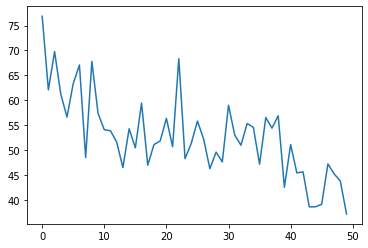

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [19]:
W1.value

array([[ 3.0926186 , -0.07604312, -1.98835284, -0.97110068, -1.32252042,
         2.03012469, -1.27587868, -2.16412252],
       [ 0.77752253,  2.17184347, -1.74193853,  0.70647464,  0.3728057 ,
        -0.26194398, -0.02695906, -0.03343409],
       [-0.49621915, -1.60418739, -1.32513349, -0.04217987,  0.36801543,
        -1.52228178,  1.11763276,  0.48446395],
       [-0.89699402,  0.03813009,  3.51917738, -0.03374336, -0.43467176,
        -0.39528446,  4.31583393, -0.57193225],
       [-0.90053915, -1.53241941,  0.59139153,  0.66686143, -0.45114387,
        -1.13929926,  1.553666  , -1.66256924],
       [-0.95828289, -1.7821414 ,  0.33548128,  1.48909133,  2.4916066 ,
        -0.3718774 ,  2.13304152,  0.79067001],
       [ 2.01318161, -0.41838242,  0.12445617, -1.20158416,  1.21013153,
         1.6925617 , -1.20689601, -1.63865728],
       [-2.60167707, -2.80506983,  0.79453497, -1.76714362,  0.75736495,
        -1.65171231,  0.73222702, -1.06978074],
       [ 0.79438534, -1.90886453

In [20]:
W2.value

array([[ 3.56118916],
       [ 9.39212543],
       [ 2.74110486],
       [11.04051283],
       [ 4.40831235],
       [ 6.52162748],
       [ 7.33160428],
       [ 7.3121919 ]])

In [21]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])